### Standardize, clean and wrangle Water Quality Portal data in Cape Cod into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Cape Cod

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

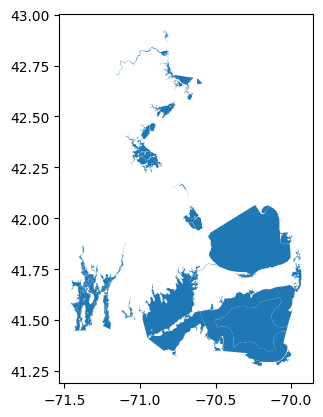

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url)  # Already 4326 standard
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(7832, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-MA,USGS Massachusetts Water Science Center,USGS-010965305,MERRIMACK R NR TYNGSBOROUGH BRIDGE TYNGSBOROUG...,Stream,NaN,1070006.0,4070.00,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096544,"STONY BROOK AT SCHOOL STREET AT CHELMSFORD, MA",Stream,NaN,1070006.0,41.57,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096546,"STONY BROOK AT CHELMSFORD, MA",Stream,NaN,1070006.0,43.60,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096548,"STONY BROOK AT N CHELMSFORD, MA",Stream,NaN,1070006.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096550,"MERRIMACK RIVER ABOVE LOWELL, MA",Stream,NaN,1070006.0,3900.00,sq mi,3900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 42.677389
LongitudeMeasure                               -71.421056
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

Signature:
location.harmonize_locations(
    df_in,
    out_EPSG=4326,
    intermediate_columns=False,
    **kwargs,
)
Docstring:
Takes a DataFrame with lat/lon in multiple Coordinate Reference Systems,
transforms them to outCRS and converts to GeoDataFrame

Parameters
----------
df_in : pandas.DataFrame
    DataFrame with the required columns to be converted to GeoDataFrame.
out_EPSG : Integer, optional
    EPSG factory code for desired output Coordinate Reference System datum.
    The default is 4326, for the WGS84 Datum used by WQP queries.
intermediate_columns : Boolean, optional
    Return intermediate columns. Default 'False' does not return these.
Keyword Arguments:
crs_col : string, optional
    Name of column in DataFrame with the Coordinate Reference System datum.
    The default is 'HorizontalCoordinateReferenceSystemDatumName'.
lat_col : string, optional
    Name of column in DataFrame with the latitude coordinate.
    The default is 'LatitudeMeasure'.
lon_col : string, opt

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(7832, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-71.4210556, 42.67738889)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-71.4210556 42.67738889)
geometry     POINT (-71.4210556 42.67738889)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'}

<Axes: >

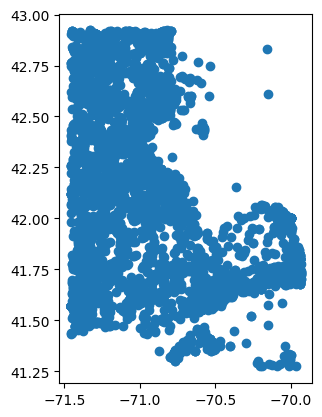

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

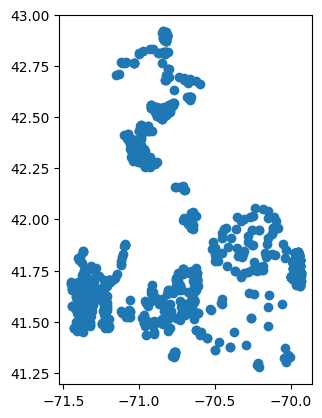

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

1313

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path,'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (8,10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,OARS,OARS - For the Assabet Sudbury & Concord River...,OARS-CND-161:20130818:0651:FM:1,2013-08-18,06:51:00,EDT,OARS-CND-161,STORET-838568413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,OARS,OARS - For the Assabet Sudbury & Concord River...,OARS-SUD-064:20130721:0610:FM:1,2013-07-21,06:10:00,EDT,OARS-SUD-064,STORET-838568309,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,2013-08-09,11:14:33,EST,CRWA-ROB,STORET-591631481,130809111433.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809SPPH01,2013-08-09,13:07:08,EST,CRWA-SP,STORET-591629799,130809130708.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-10-3215,2013-08-27,14:11:00,EDT,MASSDEP-W2386,STORET-762961436,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374260,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02302184,2023-08-24,12:00:00,EDT,USGS-422806071160302,NWIS-126010217,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
374261,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02302236,2023-08-22,15:30:00,EDT,USGS-413316070351007,NWIS-126010893,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
374262,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02302236,2023-08-22,15:30:00,EDT,USGS-413316070351007,NWIS-126010897,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
374263,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02302244,2023-08-23,13:40:00,EDT,USGS-413316070351602,NWIS-126010997,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

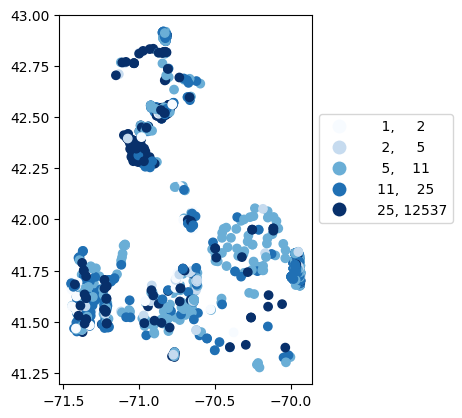

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize_generic?

##### secchi disk depth

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    4838.000000
mean      -12.459611
std       406.483787
min     -9999.000000
25%         1.600000
50%         3.500000
75%         6.000000
max        17.000000
dtype: float64
Unusable results: 264
Usable results with inferred units: 0
Results outside threshold (0.0 to 2426.443109978839): 16


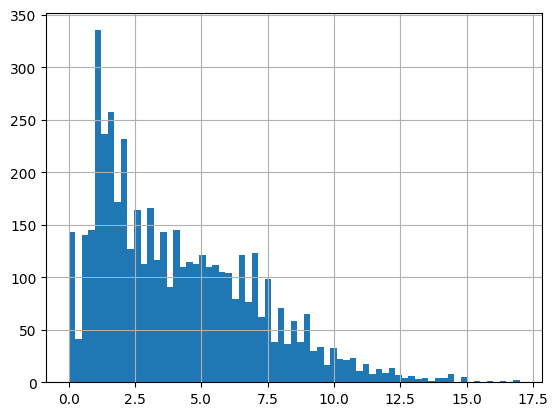

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
38,11113300-GRTKINSD,3.25,m,NaN,m,3.25 meter
144,11113300-BEADERD,4.25,m,NaN,m,4.25 meter
245,11113300-ANGSDND,3.5,m,NaN,m,3.5 meter
290,NALMS-F612242,2,m,NaN,m,2.0 meter
542,11113300-GRTKINSD,2.25,m,NaN,m,2.25 meter
...,...,...,...,...,...,...
373108,11NPSWRD_WQX-CACO_DUCK_W,16.5,m,NaN,m,16.5 meter
373109,11NPSWRD_WQX-CACO_DUCK_W,10.0,m,NaN,m,10.0 meter
373110,11NPSWRD_WQX-CACO_DUCK_W,17.0,m,NaN,m,17.0 meter
373111,11NPSWRD_WQX-CACO_DUCK_W,16.0,m,NaN,m,16.0 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
10159,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
28696,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
31530,EPA_OCMA_R1-SS-3,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
33582,EPA_OCMA_R1-R1-23,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
35703,EPA_OCMA_R1-R1-25,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
...,...,...,...,...,...,...
290607,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
290672,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
290910,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
291425,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
10159,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
28696,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
28814,NARS_WQX-NCCA10-1070,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
28960,NARS_WQX-NCCA10-1029,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
30056,NARS_WQX-NCCA10-1001,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
...,...,...,...,...,...,...
290607,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
290672,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
290910,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
291425,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-ANGSDND,42,3.796369
1,11113300-BEADERD,42,3.644048
2,11113300-CANWIND,22,6.144000
3,11113300-CAPSALD,24,2.456262
4,11113300-COBWINND,21,3.768810
...,...,...,...
681,NARS_WQX-NLA_MA-10030,1,0.950000
682,NARS_WQX-NLA_MA-10032,1,3.150000
683,NARS_WQX-NLA_RI-10051,1,1.965000
684,NARS_WQX-NLA_RI-10062,1,2.540000


C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\mapclassify\classifiers.py:257: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


<Axes: >

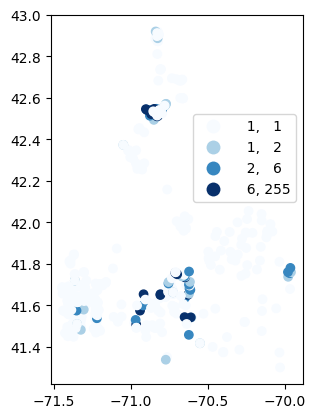

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

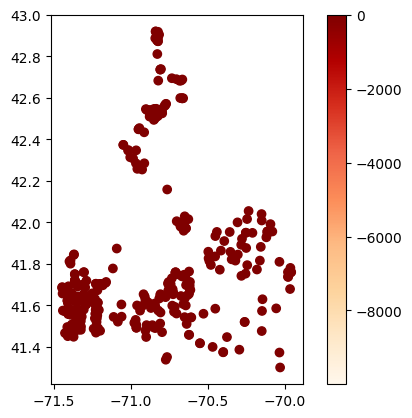

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'count' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count    105995.000000
mean         15.701527
std           7.496925
min          -6.000000
25%          10.500000
50%          16.100000
75%          21.500000
max         910.000000
dtype: float64
Unusable results: 213
Usable results with inferred units: 217
Results outside threshold (0.0 to 60.68307424731597): 115


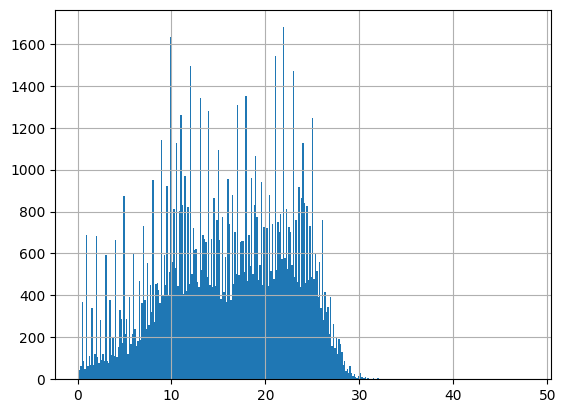

In [32]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
0,OARS-CND-161,22.18,deg C,NaN,22.18 degree_Celsius,degC
2,CRWA-ROB,23.01,deg C,NaN,23.01 degree_Celsius,degC
4,MASSDEP-W2386,20.9,deg C,NaN,20.9 degree_Celsius,degC
13,CRWA-635S,5.5,deg C,NaN,5.5 degree_Celsius,degC
18,MYRWA-MYR071,8,deg C,NaN,8.0 degree_Celsius,degC
...,...,...,...,...,...,...
374252,USGS-011008745,22.5,deg C,NaN,22.5 degree_Celsius,degC
374256,USGS-413312070351411,13.9,deg C,NaN,13.9 degree_Celsius,degC
374258,USGS-422806071160302,13.5,deg C,NaN,13.5 degree_Celsius,degC
374261,USGS-413316070351007,14.1,deg C,NaN,14.1 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
96002,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
96003,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
96004,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
96005,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
96006,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
...,...,...,...,...,...,...
97344,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
97345,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
97347,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
139690,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
279,MERRIMACK_RIVER_WATERSHED_WQX-Hayden-Schofield,8,count,NaN,NaN,count
2862,MERRIMACK_RIVER_WATERSHED_WQX-Manchester,8,count,NaN,NaN,count
3273,MERRIMACK_RIVER_WATERSHED_WQX-Nina-Scarito,8,count,NaN,NaN,count
4146,MERRIMACK_RIVER_WATERSHED_WQX-Misserville,8,count,NaN,NaN,count
4466,MERRIMACK_RIVER_WATERSHED_WQX-Ferrous,8,count,NaN,NaN,count
...,...,...,...,...,...,...
220335,11NPSWRD_WQX-SAIR_SWC_SR3,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
227259,11NPSWRD_WQX-SAIR_SWC_SR6,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
228588,11NPSWRD_WQX-SAIR_SWC_SR7,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
233026,11NPSWRD_WQX-SAIR_SWC_SRT9,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [37]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00-SPB,21,10.909524
1,11113300-00F-KLY,3,20.233333
2,11113300-01-BAK,10,20.600000
3,11113300-01-BVR,1,21.000000
4,11113300-01-CTP,39,24.438462
...,...,...,...
4958,USGS-425447071234501,1,9.400000
4959,USGS-425450070513101,1,8.800000
4960,USGS-425456071260901,1,8.000000
4961,USGS-425517071041001,2,15.750000


<Axes: >

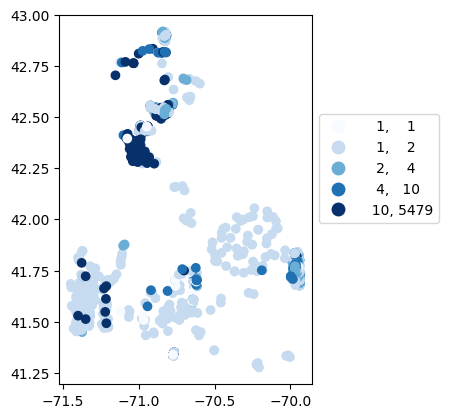

In [38]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

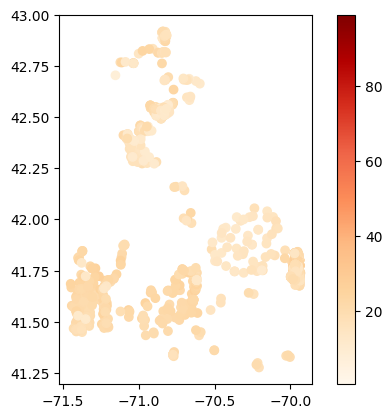

In [39]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
10,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
12,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
14,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
23,MERRIMACK_RIVER_WATERSHED_WQX-Central Catholic,10.91,mg/L,NaN,10.91 milligram / liter
...,...,...,...,...,...
368880,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
368887,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter
368890,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
368893,11NPSWRD_WQX-SAMA_EPG_SHD,9.2,mg/L,NaN,9.2 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
10,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
12,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
14,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
23,MERRIMACK_RIVER_WATERSHED_WQX-Central Catholic,10.91,mg/L,NaN,10.91 milligram / liter
...,...,...,...,...,...
368880,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
368887,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter
368890,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
368893,11NPSWRD_WQX-SAMA_EPG_SHD,9.2,mg/L,NaN,9.2 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00F-KLY,3,4.040000
1,11113300-01-BAK,10,5.697000
2,11113300-01-BVR,1,6.700000
3,11113300-01-CTP,37,6.945135
4,11113300-01-GOL,1,4.400000
...,...,...,...
2233,OARS-SUD-096,54,5.334815
2234,OARS-SUD-098,14,6.037143
2235,OARS-SUD-144,94,9.201277
2236,OARS-SUD-236,6,7.331667


<Axes: >

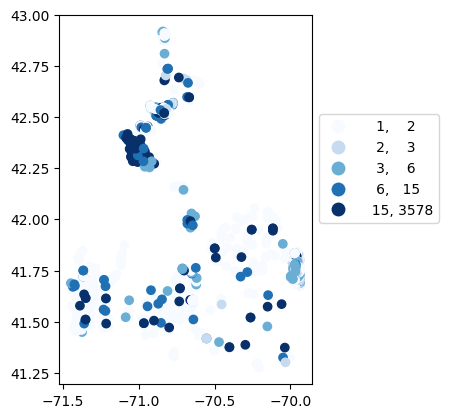

In [44]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

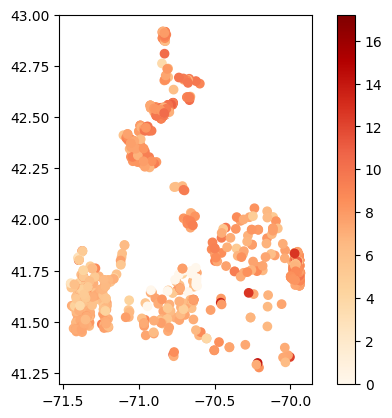

In [45]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    76591.000000
mean         6.556190
std          2.905076
min         -3.124705
25%          5.640000
50%          6.700000
75%          7.500000
max        715.000000
dtype: float64
Unusable results: 17
Usable results with inferred units: 215
Results outside threshold (0.0 to 23.98664529262258): 12


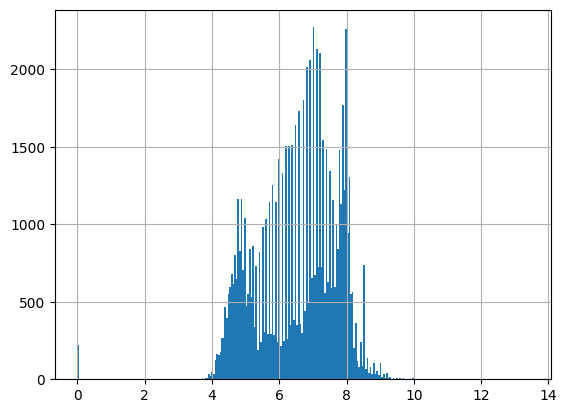

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
3,7.3,None,NaN,7.3 dimensionless
17,7.99,None,NaN,7.99 dimensionless
34,6.61,None,NaN,6.61 dimensionless
49,7.86,None,NaN,7.86 dimensionless
56,7.78,None,NaN,7.78 dimensionless
...,...,...,...,...
374253,7.7,std units,NaN,7.7 dimensionless
374257,5.3,std units,NaN,5.3 dimensionless
374259,5.3,std units,NaN,5.3 dimensionless
374262,4.7,std units,NaN,4.7 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\basis.py:95: UserWarning: Mismatched ResultTemperatureBasisText: updated from 25 deg C to @25C (units)
  warn('Mismatched {}'.format(flag))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'deg C' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count    28488.000000
mean        20.451309
std         27.758358
min          0.000000
25%          0.690000
50%         29.500000
75%         31.200000
max       4003.482834
dtype: float64
Unusable results: 217
Usable results with inferred units: 1
Results outside threshold (0.0 to 187.00145789978635): 2


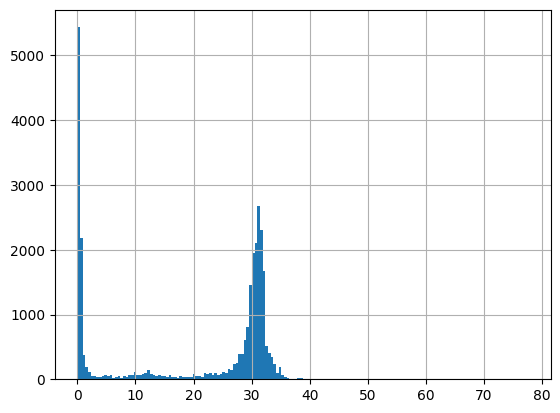

In [48]:
# Salinity
df = harmonize.harmonize_generic(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
41,30.48,ppt,NaN,30.48 Practical_Salinity_Units
44,33.3,ppth,NaN,33.3 Practical_Salinity_Units
61,0.21,ppth,NaN,0.21 Practical_Salinity_Units
64,12.3,ppth,NaN,12.3 Practical_Salinity_Units
86,31.24,ppt,NaN,31.24 Practical_Salinity_Units
...,...,...,...,...
373951,4.4,PSU,NaN,4.4 Practical_Salinity_Units
373996,3.1,PSU,NaN,3.1 Practical_Salinity_Units
374033,2.5,PSU,NaN,2.5 Practical_Salinity_Units
374143,2.4,PSU,NaN,2.4 Practical_Salinity_Units


##### Nitrogen

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    2312.000000
mean        6.722998
std       109.144150
min         0.000800
25%         0.075000
50%         0.240832
75%         1.009865
max      2800.000000
dtype: float64
Unusable results: 212
Usable results with inferred units: 0
Results outside threshold (0.0 to 661.587899252626): 6


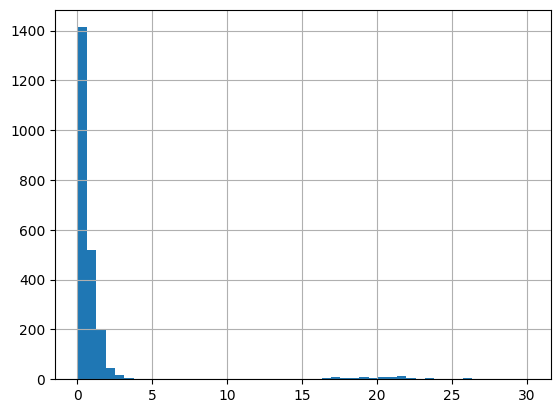

In [50]:
# Nitrogen
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
679,0.926976,mg/L,NaN,0.926976 milligram / liter
739,1.571196,mg/L,NaN,1.571196 milligram / liter
746,0.816144,mg/L,NaN,0.816144 milligram / liter
982,0.770448,mg/L,NaN,0.770448 milligram / liter
1012,0.848832,mg/L,NaN,0.848832 milligram / liter
...,...,...,...,...
374180,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
374199,0.103,mg/l,NaN,0.103 milligram / liter
374211,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
374226,0.122,mg/l,NaN,0.122 milligram / liter


##### Conductivity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'count' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count     1658.000000
mean      1165.048774
std       3717.317493
min          0.000000
25%        325.000000
50%        448.500000
75%        591.750000
max      39960.000000
dtype: float64
Unusable results: 80
Usable results with inferred units: 0
Results outside threshold (0.0 to 23468.953729993682): 19


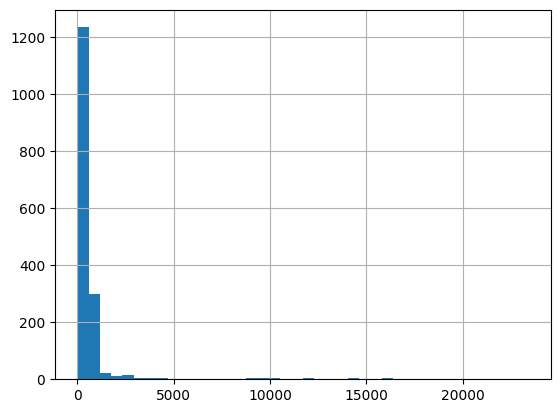

In [52]:
# Conductivity
df = harmonize.harmonize_generic(df, 'Conductivity', report=True, errors='ignore')

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
1,590,uS/cm,NaN,590.0 microsiemens / centimeter
39,349,uS/cm,NaN,349.0 microsiemens / centimeter
45,8,count,NaN,NaN
68,443,uS/cm,NaN,443.0 microsiemens / centimeter
78,67.11703531,uS/cm,NaN,67.11703531 microsiemens / centimeter
...,...,...,...,...
197524,444,uS/cm,NaN,444.0 microsiemens / centimeter
198836,441,uS/cm,NaN,441.0 microsiemens / centimeter
199588,1.5,uS/cm,NaN,1.5 microsiemens / centimeter
200198,296,uS/cm,NaN,296.0 microsiemens / centimeter


##### Chlorophyll a

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'ug/m3' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'ppb' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    3939.000000
mean        0.615776
std         3.372898
min        -0.002400
25%         0.001925
50%         0.005600
75%         0.020900
max        92.900000
dtype: float64
Unusable results: 198
Usable results with inferred units: 9
Results outside threshold (0.0 to 20.853164096683166): 29


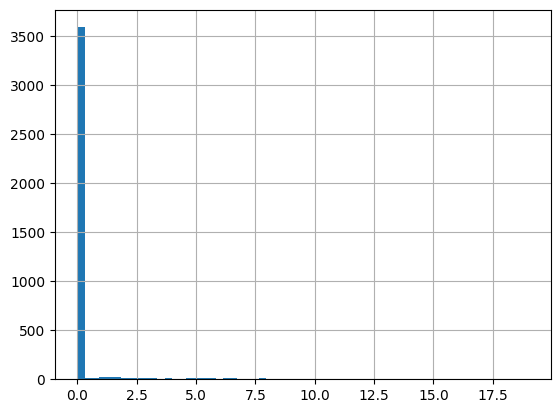

In [54]:
# Chlorophyll a
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
6,4.0,mg/m3,NaN,0.004000000000000001 milligram / liter
225,5.50,ug/L,NaN,0.0055 milligram / liter
304,9.48,ug/L,NaN,0.00948 milligram / liter
555,3.0,mg/m3,NaN,0.003000000000000001 milligram / liter
786,NaN,mg/m3,ResultMeasureValue: missing (NaN) result,NaN
...,...,...,...,...
373963,1.3,ug/l,NaN,0.0013000000000000002 milligram / liter
374183,1.8,ug/l,NaN,0.0018000000000000002 milligram / liter
374202,2.9,ug/l,NaN,0.0029 milligram / liter
374214,3.2,ug/l,NaN,0.0032 milligram / liter


##### Organic Carbon

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      5929.00000
mean       5388.77034
std       36210.41520
min      -90000.00000
25%           1.61000
50%           4.84000
75%           8.79000
max      530000.00000
dtype: float64
Unusable results: 79
Usable results with inferred units: 0
Results outside threshold (0.0 to 222651.26153962692): 40


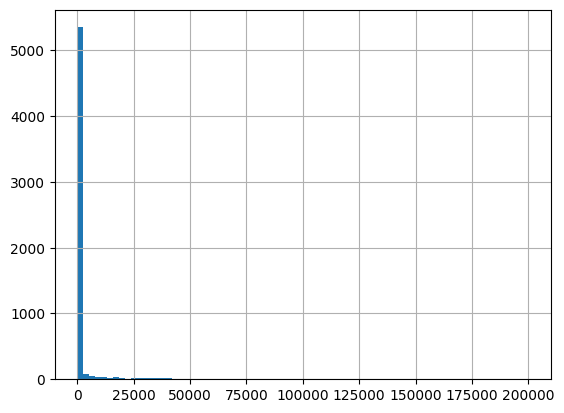

In [56]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
783,7.05,mg/L,NaN,7.05 milligram / liter
886,7.57,mg/L,NaN,7.57 milligram / liter
928,3.5,mg/L,NaN,3.5 milligram / liter
2467,3.8,mg/L,NaN,3.8 milligram / liter
3142,3.7,mg/L,NaN,3.7 milligram / liter
...,...,...,...,...
374179,8.79,mg/l,NaN,8.79 milligram / liter
374198,8.6,mg/l,NaN,8.6 milligram / liter
374210,11.7,mg/l,NaN,11.7 milligram / liter
374225,7.26,mg/l,NaN,7.26 milligram / liter


##### Turbidity (NTU)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:922: UserWarning: Bad Turbidity unit: count
  warn('Bad Turbidity unit: {}'.format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'count' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count    24897.000000
mean        20.623786
std         84.143701
min       -999.000000
25%          1.550000
50%          3.260000
75%          7.200000
max       4100.000000
dtype: float64
Unusable results: 547
Usable results with inferred units: 275
Results outside threshold (0.0 to 525.4859915343634): 159


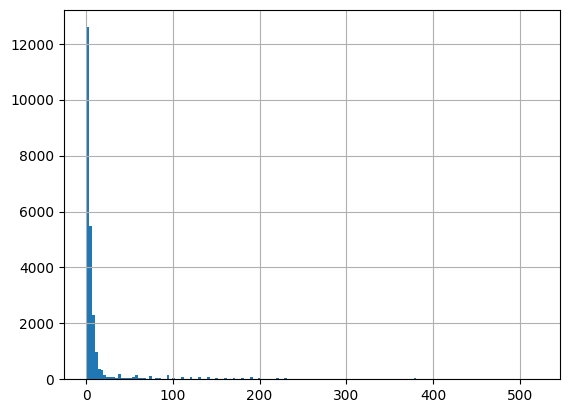

In [58]:
# Turbidity (NTU)
df = harmonize.harmonize_generic(df, 'Turbidity', report=True, errors='ignore')

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
5,4.2,NTU,NaN,4.2 Nephelometric_Turbidity_Units
9,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
16,0.984561783,NTU,NaN,0.984561783 Nephelometric_Turbidity_Units
19,4,NTU,NaN,4.0 Nephelometric_Turbidity_Units
21,2.63,NTU,NaN,2.63 Nephelometric_Turbidity_Units
...,...,...,...,...
374234,4.7,NTRU,NaN,4.7 Nephelometric_Turbidity_Units
374240,7.7,NTRU,NaN,7.7 Nephelometric_Turbidity_Units
374249,17.0,NTRU,NaN,17.0 Nephelometric_Turbidity_Units
374254,8.3,NTRU,NaN,8.3 Nephelometric_Turbidity_Units


##### Sediment

In [60]:
# Sediment
df = harmonize.harmonize_generic(df, 'Sediment', report=False, errors='ignore')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'g / H2O' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
324923,39.0,%,NaN,390.0 gram / kilogram
325310,33.0,%,NaN,330.0 gram / kilogram
334899,0.012,g,NaN,NaN
334900,0.0037,g,NaN,NaN
334901,0.0048,g,NaN,NaN
...,...,...,...,...
372083,0.0012,g,NaN,NaN
372111,0.0033,g,NaN,NaN
372149,0.0013,g,NaN,NaN
372221,0.0043,g,NaN,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [62]:
# Phosphorus
df = harmonize.harmonize_generic(df, 'Phosphorus')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [63]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
52,0.049,mg/L,NaN,NaN
54,0.024,mg/L,NaN,NaN
58,0.05,mg/L,NaN,NaN
72,0.027,mg/L,NaN,NaN
87,0.059712,mg/L,NaN,NaN
...,...,...,...,...
373585,0.006,mg/l as P,NaN,0.006 milligram / liter
373599,0.016,mg/l as P,NaN,NaN
373600,0.008,mg/l as P,NaN,0.008 milligram / liter
373607,0.047,mg/l as P,NaN,NaN


In [64]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
52,0.049,mg/L,NaN,NaN
54,0.024,mg/L,NaN,NaN
58,0.05,mg/L,NaN,NaN
72,0.027,mg/L,NaN,NaN
87,0.059712,mg/L,NaN,NaN
...,...,...,...,...
373560,0.036,mg/l as P,NaN,NaN
373570,0.021,mg/l as P,NaN,NaN
373584,0.011,mg/l as P,NaN,NaN
373599,0.016,mg/l as P,NaN,NaN


In [65]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
38826,0.023,ppm,NaN,0.023000000000000003 milligram / liter
40719,0.035,ppm,NaN,0.03500000000000001 milligram / liter
41691,0.017,ppm,NaN,0.017000000000000005 milligram / liter
41761,0.015,ppm,NaN,0.015000000000000003 milligram / liter
42438,0.015,ppm,NaN,0.015000000000000003 milligram / liter
...,...,...,...,...
373561,0.015,mg/l as P,NaN,0.015 milligram / liter
373571,0.005,mg/l as P,NaN,0.005 milligram / liter
373585,0.006,mg/l as P,NaN,0.006 milligram / liter
373600,0.008,mg/l as P,NaN,0.008 milligram / liter


In [66]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
28228,0.03525375,mg/L,NaN,NaN
28295,0.107028125,mg/L,NaN,NaN
28794,0.0697675,mg/L,NaN,NaN
29053,0.04356,mg/L,NaN,NaN
29178,0.03654875,mg/L,NaN,NaN
...,...,...,...,...
361873,530.0,mg/kg,NaN,NaN
363146,280.0,mg/kg,NaN,NaN
363902,270.0,mg/kg,NaN,NaN
364136,260.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count      2462.000000
mean        910.512591
std        6103.365912
min           0.000000
25%          24.000000
50%          93.000000
75%         400.000000
max      250000.000000
dtype: float64
Unusable results: 5122
Usable results with inferred units: 1
Results outside threshold (0.0 to 37530.70806108734): 7


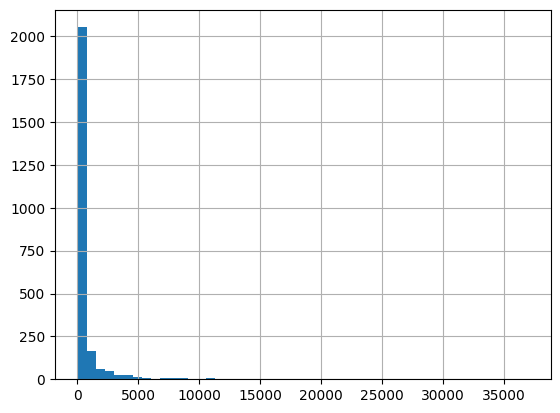

In [67]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True, errors='ignore')

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
7993,40,#/100mL,NaN,NaN
8034,9,#/100mL,NaN,NaN
8048,20,#/100mL,NaN,NaN
8215,200,#/100mL,NaN,NaN
8376,NO DATA,#/100mL,"ResultMeasureValue: ""NO DATA"" result cannot be...",NaN
...,...,...,...,...
368234,2400.0,cfu/100mL,NaN,NaN
368236,230.0,cfu/100mL,NaN,NaN
368243,30.0,cfu/100mL,NaN,NaN
368251,NaN,cfu/100mL,ResultMeasureValue: missing (NaN) result,NaN


###### Excherichia Coli

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'count' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: '%' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'CFU/

-Usable results-
count     1210.000000
mean       649.508487
std       3555.985126
min          0.000000
25%         22.250000
50%         67.500000
75%        220.000000
max      72000.000000
dtype: float64
Unusable results: 20836
Usable results with inferred units: 0
Results outside threshold (0.0 to 21985.419242848926): 7


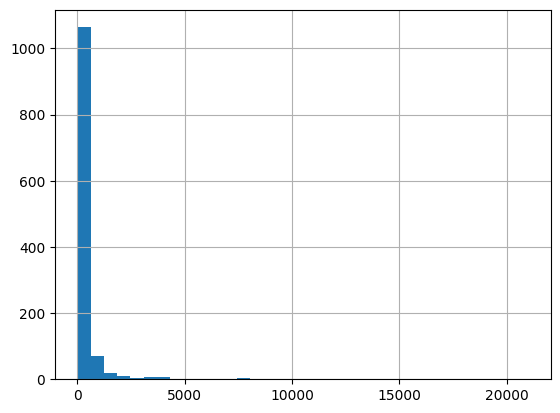

In [69]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True, errors='ignore')

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
8,96,MPN/100mL,NaN,NaN
11,58,#/100mL,NaN,NaN
15,NaN,MPN/100mL,ResultMeasureValue: missing (NaN) result,NaN
28,24200,MPN/100mL,NaN,NaN
29,7270,MPN/100mL,NaN,NaN
...,...,...,...,...
374133,170.0,MPN/100 ml,NaN,170.0 Colony_Forming_Units / milliliter
374181,59.0,MPN/100 ml,NaN,59.0 Colony_Forming_Units / milliliter
374200,1100.0,MPN/100 ml,NaN,1100.0 Colony_Forming_Units / milliliter
374212,37.0,MPN/100 ml,NaN,37.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [71]:
from harmonize_wq import convert

In [72]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 28488 
Mean: 20.451309384039828 PSU


In [73]:
# Identify extreme outliers
[x for x in lst if x >3200]

[4003.4828342857154]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [74]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [75]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
14422,804,ppth,NaN,804.0 Practical_Salinity_Units
139246,71.49,ppth,NaN,71.49 Practical_Salinity_Units
140255,70.62,ppth,NaN,70.62 Practical_Salinity_Units
191132,77.6666666666667,ppt,NaN,77.6666666666667 Practical_Salinity_Units
341887,4980.0,mg/mL @25C,ResultTemperatureBasisText: updated from 25 de...,4003.4828342857154 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [76]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [77]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
11160,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
11310,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
15194,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
22658,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
23923,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
287544,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
287582,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
287614,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
287644,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore conductivity results:

In [78]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

1               590.0 microsiemens / centimeter
39              349.0 microsiemens / centimeter
68              443.0 microsiemens / centimeter
78        67.11703531 microsiemens / centimeter
91            418.375 microsiemens / centimeter
                          ...                  
197524          444.0 microsiemens / centimeter
198836          441.0 microsiemens / centimeter
199588            1.5 microsiemens / centimeter
200198          296.0 microsiemens / centimeter
200241          442.0 microsiemens / centimeter
Name: Conductivity, Length: 1658, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [79]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
61551,39960,uS/cm,NaN,NaN,39960.0 microsiemens / centimeter
59961,33604,uS/cm,NaN,NaN,33604.0 microsiemens / centimeter
24351,30886,uS/cm,NaN,NaN,30886.0 microsiemens / centimeter
23198,30788,uS/cm,NaN,NaN,30788.0 microsiemens / centimeter
25868,30518,uS/cm,NaN,NaN,30518.0 microsiemens / centimeter
...,...,...,...,...,...
4911,0.03,uS/cm,NaN,NaN,0.03 microsiemens / centimeter
5131,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
2706,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
6575,0,uS/cm,NaN,NaN,0.0 microsiemens / centimeter


In [80]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

61551    25.494 dimensionless
59961    21.046 dimensionless
24351    19.177 dimensionless
23198     19.11 dimensionless
25868    18.926 dimensionless
                 ...         
4911      0.012 dimensionless
5131      0.012 dimensionless
2706      0.012 dimensionless
6575      0.012 dimensionless
3118      0.012 dimensionless
Name: Salinity, Length: 1658, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [81]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
61551,2015-09-11,00:15:00,EST
59961,2015-09-11,00:30:00,EST
24351,2014-11-01,18:00:00,EST
23198,2014-11-01,18:15:00,EST
25868,2014-11-01,17:45:00,EST
...,...,...,...
374260,2023-08-24,12:00:00,EDT
374261,2023-08-22,15:30:00,EDT
374262,2023-08-22,15:30:00,EDT
374263,2023-08-23,13:40:00,EDT


In [82]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\utils.py:87: UserWarning: Warning: 104530 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
61551,2015-09-11,2015-09-11 05:15:00+00:00
59961,2015-09-11,2015-09-11 05:30:00+00:00
24351,2014-11-01,2014-11-01 23:00:00+00:00
23198,2014-11-01,2014-11-01 23:15:00+00:00
25868,2014-11-01,2014-11-01 22:45:00+00:00
...,...,...
374260,2023-08-24,2023-08-24 16:00:00+00:00
374261,2023-08-22,2023-08-22 19:30:00+00:00
374262,2023-08-22,2023-08-22 19:30:00+00:00
374263,2023-08-23,2023-08-23 17:40:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [83]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


78610      0.5
81419      1.0
80696      1.2
76033      0.0
79967      5.6
          ... 
109038     2.0
109367    32.0
144837    17.0
155730     2.0
156504     2.0
Name: ResultDepthHeightMeasure/MeasureValue, Length: 1942, dtype: float64

#### Characteristic to Column (long to wide format)

In [84]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Conductivity,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_E_coli,QA_Carbon,QA_Chlorophyll,QA_pH,QA_Secchi,QA_Fecal_Coliform
61551,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_9/11/2015 00:15,2015-09-11,00:15:00,-0500,CRWA-CrescentPost,STORET-478270434,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59961,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_9/11/2015 00:30,2015-09-11,00:30:00,-0500,CRWA-CrescentPost,STORET-478270439,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24351,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_11/01/2014 18:00,2014-11-01,18:00:00,-0500,CRWA-CrescentPost,STORET-398089476,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23198,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_11/01/2014 18:15,2014-11-01,18:15:00,-0500,CRWA-CrescentPost,STORET-398089480,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25868,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_11/01/2014 17:45,2014-11-01,17:45:00,-0500,CRWA-CrescentPost,STORET-398089472,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374260,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02302184,2023-08-24,12:00:00,-0400,USGS-422806071160302,NWIS-126010217,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374261,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02302236,2023-08-22,15:30:00,-0400,USGS-413316070351007,NWIS-126010893,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374262,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02302236,2023-08-22,15:30:00,-0400,USGS-413316070351007,NWIS-126010897,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374263,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02302244,2023-08-23,13:40:00,-0400,USGS-413316070351602,NWIS-126010997,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [86]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

33827 fewer rows


In [87]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [88]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [89]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'Conductivity', 'Chlorophyll', 'Carbon', 'Turbidity',
       'Sediment', 'Phosphorus', 'TP_Phosphorus', 'TDP_Phosphorus',
       'Other_Phosphorus', 'Fecal_Coliform', 'E_coli',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Temperature', 'QA_DO', 'QA_Sediment',
       'QA_Nitrogen', 'QA_Salinity', 'QA_Turbidity', 'QA_Conductivity',
       'QA_TP_Phosphorus', 'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_E_coli', 'QA_Carbon', 'QA_Chlorophyll', 'QA_pH', 'QA_Secchi',
       'QA_Fecal_Coliform'],
      dtype='object')

In [90]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Conductivity,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_E_coli,QA_Carbon,QA_Chlorophyll,QA_pH,QA_Secchi,QA_Fecal_Coliform
61551,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_9/11/2015 00:15,CRWA-CrescentPost,STORET,NaN,NaN,NaN,NaN,25.494 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59961,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_9/11/2015 00:30,CRWA-CrescentPost,STORET,NaN,NaN,NaN,NaN,21.046 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24351,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_11/01/2014 18:00,CRWA-CrescentPost,STORET,NaN,NaN,NaN,NaN,19.177 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23198,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_11/01/2014 18:15,CRWA-CrescentPost,STORET,NaN,NaN,NaN,NaN,19.11 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25868,CRWA,Charles River Watershed Association (Massachus...,CRWA-Stormwater_11/01/2014 17:45,CRWA-CrescentPost,STORET,NaN,NaN,NaN,NaN,18.926 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['DetectionQuantitationLimitTypeName',
 'DetectionQuantitationLimitMeasure/MeasureValue',
 'DetectionQuantitationLimitMeasure/MeasureUnitCode',
 'QA_DO',
 'QA_Sediment',
 'QA_Conductivity',
 'QA_TDP_Phosphorus',
 'QA_E_coli',
 'QA_Carbon']

<Axes: >

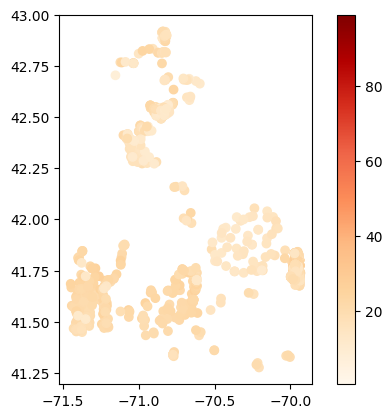

In [92]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)